In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
import torch
import gpytorch

In [2]:
entsorgung = weekday_time_series(sensor_id='entsorgung_30T')

In [3]:
entsorgung['kw'] = round(entsorgung['kw'], 2)

In [4]:
px.line(
    x=entsorgung.index, y=entsorgung.kw, 
    title='entsorgung_30T',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [4]:
time_vals = list(entsorgung.index)
np.shape(time_vals)

(240,)

In [6]:
day_range = entsorgung.index.max() - entsorgung.index.min()
day_range

Timedelta('4 days 23:30:00')

In [7]:
entsorgung.shape

(240, 8)

In [20]:
time_int_range = np.arange(0, 240*30, 30)
entsorgung['t'] = time_int_range
entsorgung['t'] = (entsorgung['t'] - entsorgung['t'].min()) / (entsorgung['t'].max() - entsorgung['t'].min())

X = entsorgung['t'].values
y = entsorgung['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

#plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

In [15]:
time_int_range = np.arange(0, 240*5, 5)
entsorgung['t'] = time_int_range

#entsorgung_final = pd.DataFrame(data=entsorgung['kw'], index=entsorgung['t'])
#entsorgung_final.reset_index(inplace=True)

X = entsorgung['t'].values
y = entsorgung['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)
time_vals_train = time_vals[:n_train]

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)
time_vals_test = time_vals[n_train:]

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

#plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

In [10]:
## new time scale ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(22, 26) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            #period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(46, 50) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            #period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [16]:
## best performing ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [15]:
## v2 - adding scaling parameters ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = local_variation_alpha


        self.covar_module = locally_short_periodic + locally_long_periodic + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [17]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 75

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.291578803778102 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.2742553230047922 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.2575832198736254 , Noise = 0.5982580780982971
Iter 4 , Loss = 1.2415275397166958 , Noise = 0.5545271635055542
Iter 5 , Loss = 1.225703914814458 , Noise = 0.5132874846458435
Iter 6 , Loss = 1.2097241878157474 , Noise = 0.4745086133480072
Iter 7 , Loss = 1.1934187663227227 , Noise = 0.43814533948898315
Iter 8 , Loss = 1.1766987652690692 , Noise = 0.40413838624954224
Iter 9 , Loss = 1.1594787847002552 , Noise = 0.3724161386489868
Iter 10 , Loss = 1.141660006239326 , Noise = 0.3428959846496582
Iter 11 , Loss = 1.1231260295268857 , Noise = 0.3154861629009247
Iter 12 , Loss = 1.103742197649778 , Noise = 0.29008743166923523
Iter 13 , Loss = 1.0833608837452497 , Noise = 0.2665949761867523
Iter 14 , Loss = 1.0618347186532109 , Noise = 0.24490055441856384
Iter 15 , Loss = 1.0390336065079582 , Noise = 0.22489391267299652
Iter 16 , Loss = 1.01485842270804

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

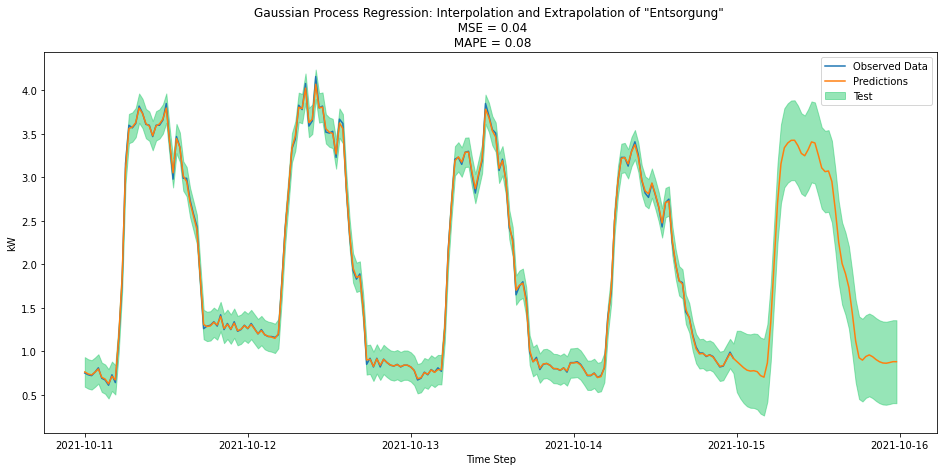

In [18]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    ## Obtain lower, upper and scale back ##
    lower, upper = observed_preds.confidence_region()
    lower *= y_train_std
    upper *= y_train_std
    lower += y_train_mean
    upper += y_train_mean

    ## Scale back observed preds.mean ##
    observed_preds = observed_preds.mean * y_train_std
    observed_preds += y_train_mean

    ## Scale back y_test ##
    #test_preds = observed_preds.mean[n_train:]
    test_preds = observed_preds[n_train:]
    #test_preds *= y_train_std
    #test_preds += y_train_mean

    y_test *= y_train_std
    y_test += y_train_mean
    
    mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    ## Scale back original data ##
    y_train *= y_train_std
    y_train += y_train_mean

    f, ax = plt.subplots(figsize=(16, 7))
    #lower, upper = observed_preds.confidence_region()
    ax.plot(time_vals_train, y_train.numpy())
    ax.plot(time_vals, observed_preds.numpy())
    ax.fill_between(time_vals, lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test', 'Uncertainty'])
    plt.xlabel('Time Step')
    plt.ylabel('kW')
    plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "Entsorgung" \n  MSE = {} \n MAPE = {}'.
    format(round(mse, 2), round(mape, 2)))
    plt.show()

In [12]:
## Scale back y_test ##
#test_preds = observed_preds.mean[n_train:]
test_preds = observed_preds[n_train:]

y_test *= y_train_std
y_test += y_train_mean

mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

In [13]:
mse, mape

(0.051236881546870484, 0.03639926049163681)

In [15]:
test_preds = observed_preds.mean[n_train:]

In [30]:
lower, upper = observed_preds.confidence_region()

In [56]:
observed_preds_scaled = observed_preds.mean * y_train_std
observed_preds_scaled += y_train_mean

In [ ]:
observed_preds_scaled

In [ ]:
observed_preds.mean

In [43]:
X_train.size()

torch.Size([192])

### Inspection of Learned Hyperparameters

Namely:
 - Lengthscale (wiggliness of the function)
 - Outputscale (if initialized) aka the variance

In [19]:
model.covar_module.lengthscale